In [1]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re

from fuzzywuzzy import process, fuzz
from notnews import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Bashar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Bashar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
FILE_PATH = '../dataverse_files/'
PROCESSED_PATH = FILE_PATH + 'processed/'
PREDICT_NEWS = False

In [3]:
def split_text(s, n):
    pieces = str(s).split()
    return (' '.join(pieces[i:i+n]) for i in range(0, len(pieces), n))

In [4]:
def split_df(df, column, num=500):
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        w_generator = split_text(presplit, num)
        for word in w_generator:
            indexes.append(i)
            new_values.append(word)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [44]:
sample_text = " VELEZ-MITCHELL:  We`ll have much more on this tomorrow at 7:00 p.m. END \
[12:00:00] KATE BOLDUAN, CNN ANCHOR: In addition to her daughter, Officer Orozco leaves  ehind her husband and two stepchildren. And we remember her and honor her today.  Thank you so much for joining us ""AT THIS HOUR."" JOHN BERMAN, CNN ANCHOR: LEGAL VIEW with Ashleigh Banfield starts now.  ANNOUNCER: This is CNN breaking news.  ASHLEIGH BANFIELD, CNN ANCHOR: Hello, everyone, I'm "

In [45]:
print (sample_text)

 VELEZ-MITCHELL:  We`ll have much more on this tomorrow at 7:00 p.m. END [12:00:00] KATE BOLDUAN, CNN ANCHOR: In addition to her daughter, Officer Orozco leaves  ehind her husband and two stepchildren. And we remember her and honor her today.  Thank you so much for joining us AT THIS HOUR. JOHN BERMAN, CNN ANCHOR: LEGAL VIEW with Ashleigh Banfield starts now.  ANNOUNCER: This is CNN breaking news.  ASHLEIGH BANFIELD, CNN ANCHOR: Hello, everyone, I'm 


In [54]:
pattern = r'\[[0-9:0-9:0-9]\]'

In [55]:
val = re.sub(pattern, '', sample_text)

In [56]:
val 

" VELEZ-MITCHELL:  We`ll have much more on this tomorrow at 7:00 p.m. END [12:00:00] KATE BOLDUAN, CNN ANCHOR: In addition to her daughter, Officer Orozco leaves  ehind her husband and two stepchildren. And we remember her and honor her today.  Thank you so much for joining us AT THIS HOUR. JOHN BERMAN, CNN ANCHOR: LEGAL VIEW with Ashleigh Banfield starts now.  ANNOUNCER: This is CNN breaking news.  ASHLEIGH BANFIELD, CNN ANCHOR: Hello, everyone, I'm "

# Predicting Soft News probability
If PREDICT_NEWS = True then will run, this is very time consuming and should be run once
After which, the files generated should be saved to disk and preserved for future analysis
  as run time could take days depending on the number of records to analyze

In [5]:
if (PREDICT_NEWS):
    
    # ingesting CNN Files
    files = glob.glob(FILE_PATH + 'cnn*.csv')
    for file in files:
        print (file)
        df = pd.read_csv( FILE_PATH + str(file), encoding = 'ISO-8859-1')
        print (f'Processing: {FILE_PATH + str(file)} ....')
        split_data = split_df(df, 'text')
        print (f'Finished splitting {FILE_PATH + str(file)} into chunks')
        soft_news_df = pred_soft_news_us(split_dat, col='text')
        print (f'Saving results for {FILE_PATH + str(file)}\n\n')
        soft_news_df.to_csv('{}soft_news_{}'.format(PROCESSED_PATH, file))
        os.rename(FILE_PATH+file, PROCESSED_PATH+file)

# Processing files

In [6]:
full_df = pd.DataFrame()

## Processing CNN Files

In [7]:
# Processing CNN files
processed_files = glob.glob(PROCESSED_PATH + 'soft_news_cnn*.csv')


for file in processed_files:
    news_df = pd.read_csv(file, encoding = 'ISO-8859-1')

    # Default to CNN and then get the index prior to splitting into mulit-records and assign all records
    #  to CNN International if the transcript contains CNN International in its text.
    news_df['channel.name'] = 'CNN'
    mod_list = news_df.loc[news_df['text'].str.contains('CNN INTERNATIONAL', case=False)]['Unnamed: 0'].tolist()    
    news_df.iloc[mod_list,2] = 'CNN International'
    
    # delete any outliers
    news_df.drop(news_df[news_df['year'] > 2100.0].index , axis=0, inplace=True)
    news_df.drop(news_df[news_df['year'] < 1900.0].index , axis=0, inplace=True)    

    # generate date field in format YYYY-MM-DD
    news_df['full_date'] = pd.to_datetime((news_df.year*10000+news_df.month*100+news_df.date),format='%Y%m%d')
    
    # cleaning up the dataframe and appending to the full dataframe
    news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us','text'])]]
    full_df = pd.concat([full_df, news_df], axis=0)
    

In [8]:
del news_df
full_df.shape

(2748284, 5)

In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748284 entries, 0 to 1114473
Data columns (total 5 columns):
 #   Column             Dtype         
---  ------             -----         
 0   channel.name       object        
 1   program.name       object        
 2   text               object        
 3   prob_soft_news_us  float64       
 4   full_date          datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 125.8+ MB


## Processing NBC/MSNBC files
these files have different formats so we'll need to process individually

### MSNBC 2003-2014 data

In [10]:
news_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc--2003--2014.csv')
news_df.rename(columns={'Source':'channel.name', 'Show':'program.name', 'Content':'text'},inplace=True)
news_df['full_date'] = pd.to_datetime(news_df.Date)

# keeping only the required columns in the dataframe
news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us','text'])]]

### MSNBC 2010-2021 data

In [11]:
news2_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc-2010--2021.csv')
news2_df.drop('program.name', axis=1, inplace=True)
news2_df.rename(columns={'Source':'channel.name', 'show_name':'program.name'},inplace=True)
news2_df['full_date'] = pd.to_datetime(news2_df.air_date)

# keeping only the required columns in the dataframe
news2_df = news2_df[news2_df.columns[news2_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us','text'])]]


/Users/Bashar/opt/anaconda3/envs/nonconform/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
print (f'Size of 2003-2014 df: {news_df.shape}')
print (f'Size of 2010-2021 df: {news2_df.shape}')

Size of 2003-2014 df: (252433, 5)
Size of 2010-2021 df: (163122, 5)


Merging the 2 dataframes to see if there is any redundant records

In [13]:
news_df.merge(news2_df, how='outer', on=['channel.name','program.name','full_date', 'prob_soft_news_us','text'])

,channel.name,program.name,text,prob_soft_news_us,full_date
0,MSNBC,HARDBALL,"b'CHRIS MATTHEWS, HOST: I`m Chris Matthews. Le...",0.117768,2002-09-24
1,MSNBC,HARDBALL,difference between the president`s speech at t...,0.048173,2002-09-24
2,MSNBC,HARDBALL,it`s a combination of worries about the lack o...,0.485402,2002-09-24
3,MSNBC,HARDBALL,going on in the war with Iraq. Congressman Rob...,0.086091,2002-09-24
4,MSNBC,HARDBALL,"it`s\ngoing to be. I mean, I think the preside...",0.265826,2002-09-24
...,...,...,...,...,...
415550,MSNBC,The 11th Hour,"But Mark, I want to ask you about another rece...",0.058611,2022-02-02
415551,MSNBC,The 11th Hour,will be because it is both safe and effective....,0.104432,2022-02-02
415552,MSNBC,The 11th Hour,clinical trials showed two shots of the vaccin...,0.080886,2022-02-02
415553,MSNBC,The 11th Hour,the worst is over? REDLENER: We can hope that ...,0.301714,2022-02-02


In [14]:
full_df = pd.concat([full_df, news_df], axis=0)

In [15]:
full_df.shape

(3000717, 5)

In [16]:
del news2_df

### Processing NBC News data

In [17]:
news_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc.csv', encoding = 'ISO-8859-1')
news_df['channel.name'] = 'NBC News'

In [18]:
news_df.drop(news_df[news_df['date'].isnull()].index, axis=0, inplace=True)

In [19]:
news_df = news_df.drop(news_df[news_df['year'] > 2100.0].index , axis=0)
news_df = news_df.drop(news_df[news_df['year'] < 1900.0].index , axis=0)    

news_df['full_date'] = pd.to_datetime((news_df.year*10000+news_df.month*100+news_df.date),format='%Y%m%d')

In [20]:
# keeping only the required columns in the dataframe
news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us','text'])]]

full_df = pd.concat([full_df, news_df], axis=0)

In [21]:
full_df.drop(full_df[full_df['program.name'].isnull()].index, axis=0, inplace=True)
full_df.shape

(3054223, 5)

In [22]:
del news_df

# Cleaning Data

In [23]:
def get_matching_shows(df):
    unique_shows = df['program.name'].unique().tolist()
    
    # creating a tuple with each unique show and its closest matches with FuzzyWuzzy token sort ration method
    match_tuple = [(x,) + i
                   for x in unique_shows
                   for i in process.extract(x,unique_shows, scorer=fuzz.token_sort_ratio)]

    analysis_df = pd.DataFrame(columns=['program.name','matched.program', 'score'], data=match_tuple)
    
    return analysis_df

In [24]:
matching_show_df = get_matching_shows(full_df)

# filter for shows that only match > 70
matching_show_df = matching_show_df[(matching_show_df.score > 80) & (matching_show_df.score < 100)]
matching_show_df.to_csv('../dataverse_files/raw_matching_shows.csv')

After exporting the matching program names with fuzzy wuzzy, manually went through the file and only kept one show to replace each program.  If a show listed was not to be changed then the entry was ommitted.  This was used as a lookup in the code below to do most of the heavy lifting of converting shows into the same string.  After that we still had some that had to be edited manaually

In [25]:
matching_show_df = pd.read_csv('../dataverse_files/show_lookup.csv')
matching_show_df.reset_index(drop=True)
matching_show_df.drop(['Unnamed: 0', 'score'],axis=1, inplace=True)
matching_show_df

,program.name,matched.program
0,CNN International Best Of Q&A;,CNN INTERNATIONAL Q&A
1,CNN International Best Of Insight,CNN INTERNATIONAL INSIGHT
2,CNN AHEAD OF THE CURVE,Ahead Of The Curve
3,CNN BREAKING NEWS,Breaking News
4,CNN BURDEN OF PROOF,Burden of Proof
...,...,...
77,Hardball with Chris Matthews' forWednesday,Hardball with Chris Matthews
78,The Rachel Maddow Show' Friday,The Rachel Maddow Show
79,The Last Word with Lawrence O'Donnell' Wednesday,The Last Word with Lawrence O'Donnell
80,The Last Word with Lawrence O'Donnell' forThur...,The Last Word with Lawrence O'Donnell


In [26]:
full_df.loc[full_df['program.name'].isin(matching_show_df['program.name']),['program.name']] = matching_show_df['matched.program']


In [27]:
full_df['program.name'] = full_df['program.name'].str.title()

In [28]:
full_df.drop(full_df[full_df['program.name'].isnull()].index, axis=0, inplace=True)

In [29]:
sorted(full_df['program.name'].unique().tolist())

['@Thishour With Berman And Michaela',
 'Ac 360 Later',
 'Ahead Of The Curve',
 'All In With Chris Hayes',
 'Amanpour',
 'America`S Voices',
 'American Morning',
 'American Morning With Paula Zahn',
 'American Morning: Wake Up Call',
 'American Nightly Scoreboard',
 'Anderson Cooper 360 Degrees',
 'Anthony Bourdain Parts Unknown',
 'Around The World',
 'Asia Tonight',
 'At This Hour',
 'Ballot Bowl 2008',
 'Beck',
 'Biz Asia',
 'Both Sides With Jesse Jackson',
 'Breaking News',
 'Buchanan & Press',
 'Burden Of Proof',
 'Business Traveler',
 'Business Unusual',
 'Campbell Brown',
 'Campbell Brown: No Bias, No Bull',
 'Capital Gang',
 'Chicagoland',
 'Closing Bell',
 'Cnn 10',
 'Cnn American Morning With Paula Zahn',
 'Cnn American Stories',
 'Cnn Christmas Around The World',
 'Cnn Connie Chung Tonight',
 'Cnn Daybreak',
 'Cnn Election Center',
 'Cnn Go',
 'Cnn He Said/She Said',
 'Cnn Hotspots',
 'Cnn In The Money',
 'Cnn Insight',
 'Cnn International Asia Tonight',
 'Cnn International 

In [30]:
# Fixing the shows that fuzzy wuzzy didn't catch, the list was small enough that doing it by hand was a lot quicker
full_df.loc[full_df['program.name']=='Ac 360 Degrees','program.name'] = 'Anderson Cooper 360 Degrees'
full_df.loc[full_df['program.name']=='American Morning With Paula Zahn','program.name'] = 'American Morning'
full_df.loc[full_df['program.name']=='Cnn American Morning With Paula Zahn','program.name'] = 'American Morning'
full_df.loc[full_df['program.name']=='Cnn International Q&A;','program.name'] = 'Cnn International Q&A'
full_df.loc[full_df['program.name']=='Cnn Late Edition With Wolf Blitzer','program.name'] = 'Cnn Late Edition'
full_df.loc[full_df['program.name']=='Cnn News Night Aaron Brown','program.name'] = 'Cnn Newsnight With Aaron Brown'
full_df.loc[full_df['program.name']=='Cnn Newsnight Aaron Brown','program.name'] = 'Cnn Newsnight With Aaron Brown'
full_df.loc[full_df['program.name']=='Cnn Page One With Nick Charles','program.name'] = 'Cnn Page One'
full_df.loc[full_df['program.name']=='Cnn Saturday Edition','program.name'] = 'Cnn Saturday'
full_df.loc[full_df['program.name']=='Cnn Showdown On Iraq','program.name'] = 'Cnn Showdown: Iraq'
full_df.loc[full_df['program.name']=='Cnn The Point With Greta Van Susteren','program.name'] = 'Cnn The Point'
full_df.loc[full_df['program.name']=='Cnn The Spin Room Corrected Copy','program.name'] = 'Cnn The Spin Room'
full_df.loc[full_df['program.name']=="CNN'S AMANPOUR",'program.name'] = 'Amanpour'
full_df.loc[full_df['program.name']=='Cnn&Time;','program.name'] = 'CNN/Time'
full_df.loc[full_df['program.name']=='Evans, Novak, Hunt & Shields','program.name'] = 'Cnn Evans, Novak, Hunt & Shields'
full_df.loc[full_df['program.name']=='Hardball With Chris Matthews','program.name'] = 'Hardball'
full_df.loc[full_df['program.name']=="Hardball With Chris Matthews' Fortuesday",'program.name'] = 'Hardball'
full_df.loc[full_df['program.name']=="Hardball With Chris Matthews' Forwednesday",'program.name'] = 'Hardball'
full_df.loc[full_df['program.name']=='Jane Velez-Mitchell','program.name'] = 'Issues With Jane Velez-Mitchell'
full_df.loc[full_df['program.name']=="Judy Woodruffs'S Inside Politics",'program.name'] = "Judy Woodruff'S Inside Politics"
full_df.loc[full_df['program.name']=='Melissa-Harris-Perry','program.name'] = 'The Melissa Harris-Perry Show'
full_df.loc[full_df['program.name']=='Melissa Harris-Perry','program.name'] = 'The Melissa Harris-Perry Show'
full_df.loc[full_df['program.name']=='Msnbc Hardball','program.name'] = 'Hardball'
full_df.loc[full_df['program.name']=='Politicsnation','program.name'] = 'Politics Nation'
full_df.loc[full_df['program.name']=='The Ed Show With Ed Schultz','program.name'] = 'The Ed Show'
full_df.loc[full_df['program.name']=='The Ed Show Forthursday,July 19Th','program.name'] = 'The Ed Show'
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O' Donnell",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O'Donnell' Forthursday",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O'Donnell' Fortuesday",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O'Donnell' Fothursday",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O'Donnell' Wednesday",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=='The Point With Greta Van Susteren','program.name'] = 'The Point'
full_df.loc[full_df['program.name']=="The Rachel Maddow Show'Forã\x82Â\xa0 Monday",'program.name'] = 'The Rachel Maddow Show'
full_df.loc[full_df['program.name']=='World Beat','program.name'] = 'Worldbeat'


In [31]:
# final cosmetic changes to make it look more presentable
full_df['program.name'] = full_df['program.name'].str.replace('Cnn','CNN')
full_df['program.name'] = full_df['program.name'].str.replace('Msnbc','MSNBC')
full_df['program.name'] = full_df['program.name'].str.replace("'S","'s")

# Analysis Plots

Filtering for shows that have had at least 100 transcripts, even though we split the long transcipts into mulitple lines if it was over 5000 words long this is a good enough estimate at this point

In [32]:
filt_soft_news_df = full_df[full_df.groupby(['program.name','channel.name'])['prob_soft_news_us'].transform('count') > 100]


In [33]:
# Comparing the size of the original dataframe to the new filtered dataframe
print (f'Original dataframe size: {full_df.shape}')
print (f'Filtered dataframe size: {filt_soft_news_df.shape}')

Original dataframe size: (1926529, 5)
Filtered dataframe size: (1921307, 5)


In [34]:
soft_news_df_grp = filt_soft_news_df.groupby(['program.name','channel.name'])['prob_soft_news_us'].mean().reset_index()
soft_news_df_grp = soft_news_df_grp.sort_values(['channel.name','prob_soft_news_us','program.name'])

[Text(0.5, 1.0, 'Soft news by show in Channel')]

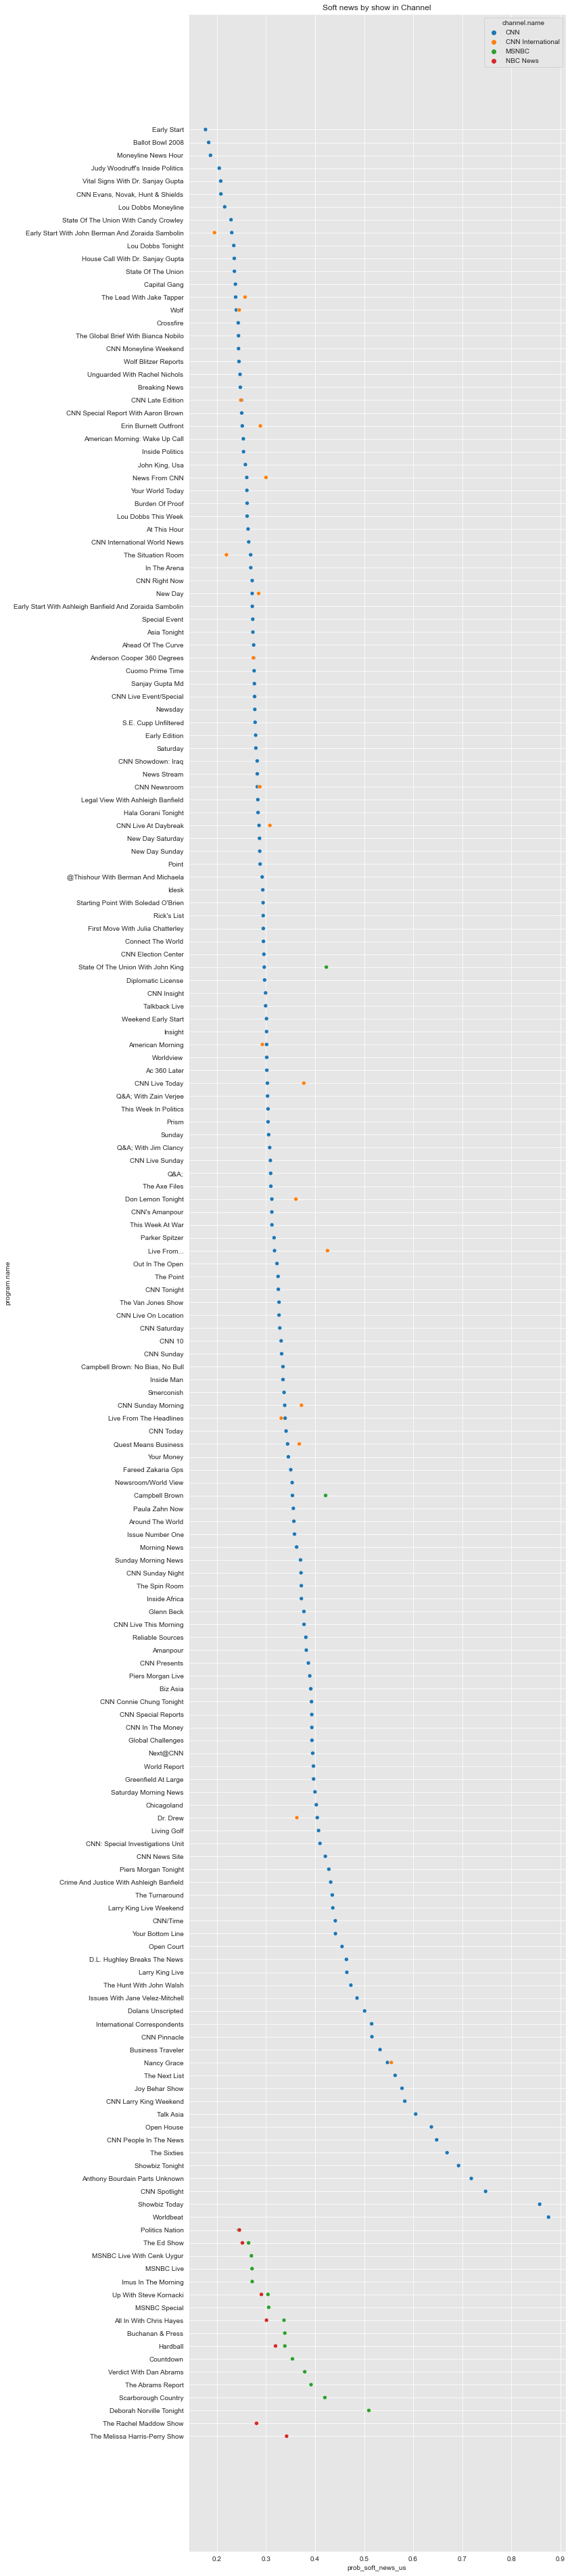

In [40]:
# Use column names of df for the different parameters x, y, color, ...

fig, ax = plt.subplots(figsize=(10,soft_news_df_grp.shape[0]/3))

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.scatterplot(x="prob_soft_news_us", y="program.name", data=soft_news_df_grp,
                      hue="channel.name", ax=ax, size_norm=.2
                ).set(title='Soft news by show in Channel')

[Text(0.5, 1.0, 'Channel Averages')]

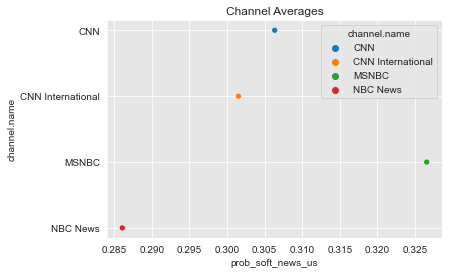

In [36]:
# Showing channel averages
channel_averages = filt_soft_news_df.groupby('channel.name')['prob_soft_news_us'].mean().reset_index()
channel_averages = channel_averages.sort_values('channel.name')

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.scatterplot(x="prob_soft_news_us", y="channel.name", data=channel_averages,
                      hue="channel.name"
                ).set(title='Channel Averages')

## Displaying sample transcripts

In [37]:
pd.set_option('display.max_colwidth',100)

high_soft_df = full_df[full_df['prob_soft_news_us'] > 0.999626 ].sample(n=20)
low_soft_df = full_df[full_df['prob_soft_news_us'] == 0].sample(n=20)

In [38]:
high_soft_df[['text','prob_soft_news_us']]

,text,prob_soft_news_us
534606,"First of all, the date, it's February 22, 2018. It's only approximately one month ago. It's an e...",1.000000
897969,"BROOKE BALDWIN, CNN ANCHOR: Hi there. I'm Brooke Baldwin at the CNN World Headquarters here in A...",0.999626
806760,is not congruent with the position that he's putting forth now. They're going to argue against w...,0.999626
716362,city about $57 million a day. Travel advisories around the world are furthering the impact on to...,0.999626
897646,"and, if at all, that punk affected this doc. BOUDREAU: I was going to meet James O'Keefe. He was...",0.999626
897896,"very seriously. What's interesting in Europe, however, is that European governments are not chan...",0.999626
230933,"(COMMERCIAL BREAK) [13:34:53] WOLF BLITZER, CNN HOST: President Obama's come under some criticis...",0.999626
836349,"[05:00:00] (MUSIC PLAYING) ANNA COREN, CNN ANCHOR (voice-over): President Trump threatens and th...",0.999626
325904,asking to you do the same especially the young people here. It isn't that often in your life whe...,0.999626
57395,"CORRESPONDENT: And good morning to you, Daryn. As you walk through the city here, you don't see ...",0.999626


In [39]:
low_soft_df[['text','prob_soft_news_us']]

,text,prob_soft_news_us
881171,"Yes, sadly, a lot is not going to happen in the coming months. All right, Erica Hill reporting f...",0.0
604230,"there just a few weeks ago, we were at the aftermath of an area that had been bombed repeatedly,...",0.0
865385,we do absolutely believe that his views should be aired. That is necessary that we know that som...,0.0
109884,"one free hour in day and you've got to choose between a nap or exercise, pick the nap. Give your...",0.0
175383,"work. And he says he is not a hero. Mr. Cordova, we disagree. You are, indeed. And she said, app...",0.0
152290,"up anywhere in the world, it sends a strong message. And it means many things -- potential reven...",0.0
122641,"said, at some point, that these men were accused. They've been accused of nothing. They are not ...",0.0
603558,"Trump chooses to weigh in and the times she doesn't. This is one of those times, and we're heari...",0.0
257505,Issa's op-ed on this on cnn.com.,0.0
341943,"More news at the top of the hour. ""THE VITAL SIGNS WITH DR. SANJAY GUPTA"" begins right now.",0.0


In [42]:
sample_df = full_df.sample(n=200)
sample_df.to_csv('../dataverse_files/sample_transcripts.csv')